In [ ]:
!git clone https://github.com/Multi-Class-Recyclables-classification/RecycleNet

Cloning into 'RecycleNet'...
remote: Enumerating objects: 13025, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 13025 (delta 0), reused 0 (delta 0), pack-reused 13021 (from 2)
Receiving objects: 100% (13025/13025), 225.54 MiB | 15.56 MiB/s, done.
Resolving deltas: 100% (749/749), done.
Updating files: 100% (13352/13352), done.


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from torchvision import models


In [ ]:
data_path=os.path.join(os.getcwd(),"RecycleNet","Datasets")

### Exploring Dataset Distribution
Let's expand on simply counting files in one directory. We will now count the number of images in each of the training subfolders (categories) and visualize their distribution. This gives a better overview of the dataset balance.

In [ ]:

def explore(name:str):

  train_data_path = os.path.join(data_path, name)


  categories = [d for d in os.listdir(train_data_path) ]

  image_counts = {}
  image_dim={}
  for category in categories:
      category_path = os.path.join(train_data_path, category)
      image_counts[category] = len(os.listdir(category_path))
      # image_dim[category]=

  # Convert to DataFrame for easier visualization and display
  image_counts_df = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Count'])

  print("Image counts per category:")
  display(image_counts_df)
    # Visualize the image counts
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Category', y='Count', data=image_counts_df, palette='viridis', hue='Category', legend=False)
  plt.title(f'Number of Images per Category in {name} Dataset')
  plt.xlabel('Recycling Category')
  plt.ylabel('Number of Images')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()






Image counts per category:


,Category,Count
0,paper,700
1,cardboard,700
2,biological,700
3,trash,700
4,metal,700
5,plastic,700
6,glass,471


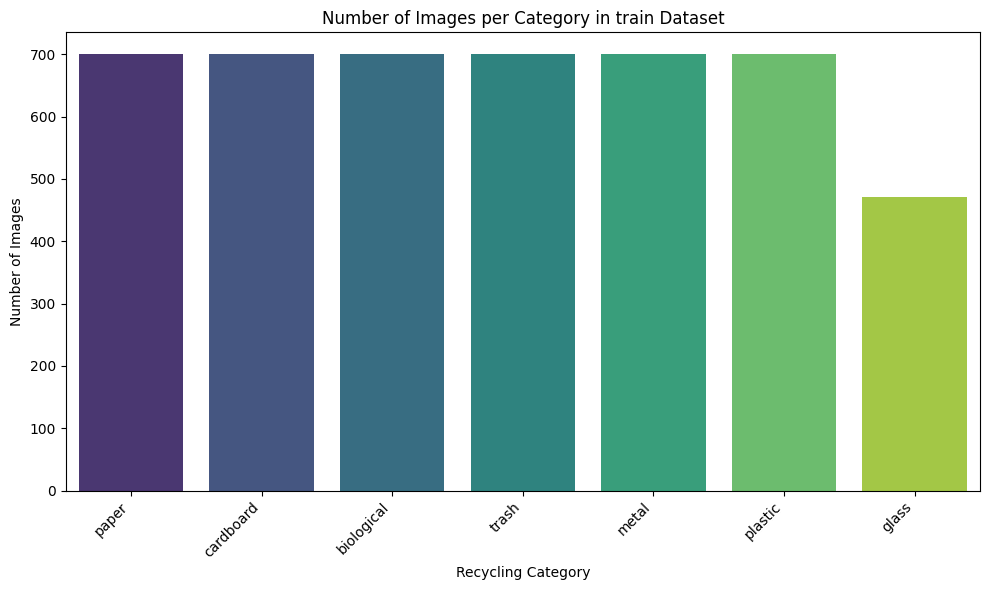

In [ ]:
explore("train")

Image counts per category:


,Category,Count
0,paper,150
1,cardboard,150
2,biological,150
3,trash,150
4,metal,150
5,plastic,150
6,glass,102


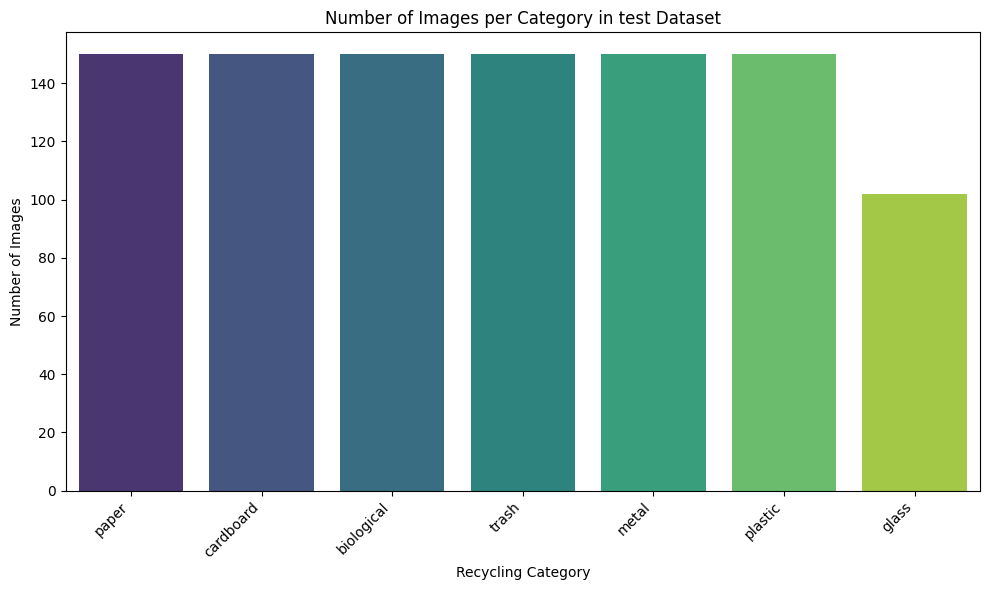

In [ ]:
explore("test")

Image counts per category:


,Category,Count
0,paper,150
1,cardboard,150
2,biological,150
3,trash,150
4,metal,150
5,plastic,150
6,glass,101


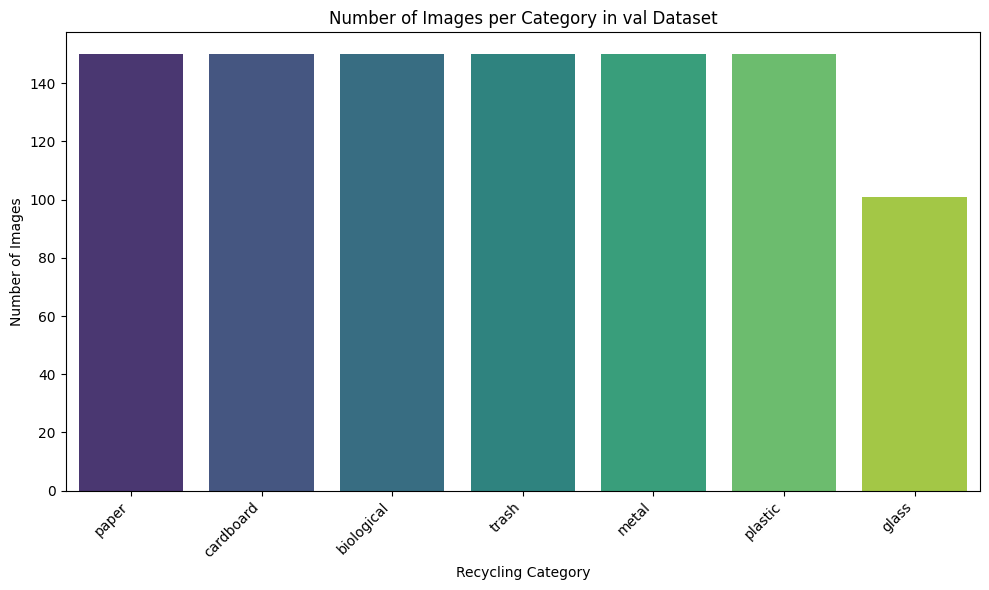

In [ ]:
explore("val")

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

### Create Datasets and DataLoaders
Now that we have defined our image transformations, we will use `torchvision.datasets.ImageFolder` to create our datasets for the training, validation, and test sets. Then, we'll create `DataLoader` instances to handle batching and efficient loading of the data during model training.

In [ ]:
# Define batch size
BATCH_SIZE = 32

# Create ImageFolder datasets for train, validation, and test
train_dataset = datasets.ImageFolder(os.path.join(data_path, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_path, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_path, 'test'), transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
train_dataset.class_to_idx

{'biological': 0,
 'cardboard': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RubbishCNN(num_classes=7).to(device)

class RubbishCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(RubbishCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # 224/2/2/2/2 = 14
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten
        x = x.view(-1, 256 * 14 * 14)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RubbishCNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=25):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_acc = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_acc:.2f}%')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=25)

Epoch [1/25], Loss: 1.7278, Accuracy: 30.27%
Epoch [2/25], Loss: 1.5822, Accuracy: 37.55%
Epoch [3/25], Loss: 1.5114, Accuracy: 40.51%
Epoch [4/25], Loss: 1.4363, Accuracy: 45.04%
Epoch [5/25], Loss: 1.3906, Accuracy: 48.02%
Epoch [6/25], Loss: 1.3656, Accuracy: 49.90%
Epoch [7/25], Loss: 1.3153, Accuracy: 51.38%
Epoch [8/25], Loss: 1.2798, Accuracy: 53.29%
Epoch [9/25], Loss: 1.2390, Accuracy: 55.88%
Epoch [10/25], Loss: 1.2351, Accuracy: 54.74%
Epoch [11/25], Loss: 1.1814, Accuracy: 57.80%
Epoch [12/25], Loss: 1.1665, Accuracy: 58.25%
Epoch [13/25], Loss: 1.1398, Accuracy: 58.83%
Epoch [14/25], Loss: 1.1261, Accuracy: 59.92%
Epoch [15/25], Loss: 1.1263, Accuracy: 60.01%
Epoch [16/25], Loss: 1.0933, Accuracy: 61.66%
Epoch [17/25], Loss: 1.0541, Accuracy: 62.73%
Epoch [18/25], Loss: 1.0608, Accuracy: 63.16%
Epoch [19/25], Loss: 1.0360, Accuracy: 63.48%
Epoch [20/25], Loss: 1.0187, Accuracy: 64.35%
Epoch [21/25], Loss: 0.9853, Accuracy: 65.70%
Epoch [22/25], Loss: 1.0049, Accuracy: 65.4

In [ ]:
from torch.cuda import device
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

for param in resnet.parameters():
    param.requires_grad = False


for param in resnet.layer4.parameters():
    param.requires_grad = True

num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 7)
)

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


optimizer = torch.optim.Adam([
    {'params': resnet.layer4.parameters(), 'lr': 1e-5},
    {'params': resnet.fc.parameters(), 'lr': 1e-4}
])

In [ ]:
epochs = 10

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")



    resnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = resnet(imgs)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Validation Accuracy: {acc:.4f}")




Epoch [1/10] - Loss: 1.0100
Validation Accuracy: 0.8801
Epoch [2/10] - Loss: 0.5281
Validation Accuracy: 0.8961
Epoch [3/10] - Loss: 0.4287
Validation Accuracy: 0.9141
Epoch [4/10] - Loss: 0.3708
Validation Accuracy: 0.9261
Epoch [5/10] - Loss: 0.3395
Validation Accuracy: 0.9301
Epoch [6/10] - Loss: 0.3084
Validation Accuracy: 0.9311
Epoch [7/10] - Loss: 0.2842
Validation Accuracy: 0.9381
Epoch [8/10] - Loss: 0.2779
Validation Accuracy: 0.9301
Epoch [9/10] - Loss: 0.2542
Validation Accuracy: 0.9311
Epoch [10/10] - Loss: 0.2297
Validation Accuracy: 0.9361


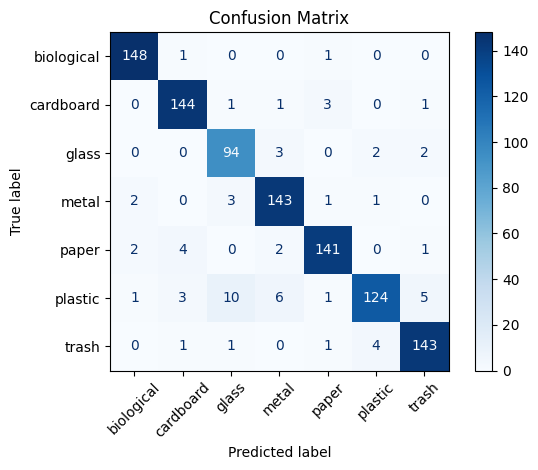

Classification Report:

              precision    recall  f1-score   support

  biological       0.97      0.99      0.98       150
   cardboard       0.94      0.96      0.95       150
       glass       0.86      0.93      0.90       101
       metal       0.92      0.95      0.94       150
       paper       0.95      0.94      0.95       150
     plastic       0.95      0.83      0.88       150
       trash       0.94      0.95      0.95       150

    accuracy                           0.94      1001
   macro avg       0.93      0.94      0.93      1001
weighted avg       0.94      0.94      0.94      1001



In [ ]:


# ----------------------------
# COLLECT ALL TRUE + PRED LABELS
# ----------------------------
all_preds = []
all_labels = []

resnet.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = resnet(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ----------------------------
# CONFUSION MATRIX
# ----------------------------
cm = confusion_matrix(all_labels, all_preds)
classes = val_loader.dataset.classes  # class names from ImageFolder

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap='Blues')

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ----------------------------
# CLASSIFICATION REPORT
# ----------------------------
report = classification_report(all_labels, all_preds, target_names=classes)
print("Classification Report:\n")
print(report)


In [ ]:
# ----------------------------
# SAVE MODEL
# ----------------------------
torch.save(resnet.state_dict(), "resnet_feature_extractor_7class.pth")
print("Model saved.")

Model saved.
